In [1]:
import numpy as np
from keras.layers import Embedding
from keras.layers import Input, Dense, LSTM, TimeDistributed
from keras.models import Model
from collections import defaultdict
from collections import Counter
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
import re
import pickle
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.
C:\Python\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Python\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Python\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Python\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning:

In [2]:
class Mimic:
    UNK = '<UNK>'
    START = '<START> '
    END = ' <END>'
    
    def __init__(self, word2vec=None, model=None, vocab=None):
        if vocab==None and model==None:
            embeddingWeights = self._createVocab(word2vec)
            self._buildModel(embeddingWeights)
        else:
            self.model = model
            self.embeddingDim = vocab['embeddingDim']
            self.vocabSize = vocab['vocabSize']
            self.word2index = vocab['word2index']
            self.index2word = vocab['index2word']
            
        self._extractBot()
        
    def _createVocab(self, word2vec):
        mn = min([j for i in word2vec.values() for j in i])
        mx = max([j for i in word2vec.values() for j in i])
        self.embeddingDim = len(list(word2vec.values())[0])
        
        word2vec[self.START] = np.random.uniform(mn,mx,size=self.embeddingDim)
        word2vec[self.END] = np.random.uniform(mn,mx,size=self.embeddingDim)
        
        self.vocabSize = len(word2vec) + 1
        self.word2index = defaultdict(int)
        self.index2word = defaultdict(str)
        
        self.word2index[self.UNK] = 0
        self.index2word[0] = self.UNK
        
        embeddingWeights = np.zeros((self.vocabSize +1, self.embeddingDim))
        for index,(word,vector) in enumerate(word2vec.items()):
            self.word2index[word] = index+1
            self.index2word[index+1] = word
            embeddingWeights[index+1] = vector
        
        return embeddingWeights
    
    def _buildModel(self, embeddingWeights):
        embedLayer = Embedding(input_dim=self.vocabSize+1, output_dim=self.embeddingDim, trainable=True,)
        embedLayer.build((None,))
        embedLayer.set_weights([embeddingWeights])
        
        encoderInputs = Input(shape=(None, ), dtype='int32',)
        encoderEmbedding = embedLayer(encoderInputs)
        encoderLSTM = LSTM(self.embeddingDim, return_state=True)
        _ , state_h, state_c = encoderLSTM(encoderEmbedding)

        decoderInputs = Input(shape=(None, ), dtype='int32',)
        decoderEmbedding = embedLayer(decoderInputs)
        decoderLSTM = LSTM(self.embeddingDim, return_state=True, return_sequences=True)
        decoderOutputs, _, _ = decoderLSTM(decoderEmbedding, initial_state=[state_h, state_c])

        decoderDense = TimeDistributed(Dense(self.vocabSize, activation='softmax'))
        outputs = decoderDense(decoderOutputs)
        self.model = Model([encoderInputs, decoderInputs], outputs)
        self.model.compile(optimizer='adam', loss ='categorical_crossentropy', metrics = ['accuracy'])
    
    def getSequences(self, sents, decode=False):
        seqs = []
        for sent in sents:
            
            if decode:
                seqs.append([self.word2index[self.START]]+
                            [self.word2index[word] for word in sent.split()]
                            +[self.word2index[self.END]])
            else:
                seqs.append([self.word2index[word] for word in sent.split()])
        return seqs
    
    
    def getDecodeOut(self, decodeIn, maxSentLen):
        decodeOut = []
        for sent in decodeIn:
            sent = sent[1:]
            oneHot = [[0. for i in range(self.vocabSize)] for j in range(maxSentLen)]
            for idx,word in enumerate(sent):
                oneHot[idx][word] = 1.
            decodeOut.append(oneHot)
        return np.array(decodeOut)
    
    def _extractBot(self):
        _, stateH, stateC = self.model.layers[3](self.model.layers[2](self.model.inputs[0]))
        self.encoder = Model(self.model.inputs[0], [stateH, stateC])
        
        inputH = Input(shape=(None,))
        inputC = Input(shape=(None,))

        decoderOut, stateH2, stateC2 = self.model.layers[4](self.model.layers[2](self.model.inputs[-1]), 
                                                                    initial_state=[inputH, inputC])
        self.decoder = Model([self.model.inputs[-1]] + [inputH, inputC], 
                                   [self.model.layers[-1](decoderOut)] + [stateH2, stateC2])
        
    
    def dataGen(self, encoderIn, decoderIn, batchSize=10):
        maxSentLen = max([len(i) for i in decoderIn])
        number_of_batches = len(encoderIn)/batchSize
        padEn = pad_sequences(encoderIn, dtype='int32', padding='post', truncating='post')
        padDe = pad_sequences(decoderIn, dtype='int32', padding='post', truncating='post')
        counter=0
        while(True):
            prev = batchSize*counter
            nxt = batchSize*(counter+1)
            decoderOut = self.getDecodeOut(decoderIn[prev:nxt], maxSentLen)
            counter+=1
            yield [padEn[prev:nxt], padDe[prev:nxt]], decoderOut

            if counter>=number_of_batches:
                counter=0
        
    
    
    def fit(self, encoderText, decoderText, epochs=20, batchSize=10, save=False, plot=False):
        encoderIn = self.getSequences(encoderText)
        decoderIn = self.getSequences(decoderText, decode=True)
        evalutaion = self.model.fit_generator(self.dataGen(encoderIn, decoderIn, batchSize=batchSize), 
                                      epochs=epochs, steps_per_epoch = len(encoderIn)/batchSize)
        self._extractBot()
        if save:
            self.saveModel('mimic-{}-{}'.format(batch,round(accuracy[-1],3)))
        if plot:
            plt.plot(evalutaion.history['acc'])
            plt.title('Model Accuracy')
            plt.ylabel('Accuracy')
            plt.xlabel('Epochs')
            plt.show()
            
            plt.plot(evalutaion.history['loss'])
            plt.title('Model Loss')
            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            plt.show()
            
            
        
    def talk(self, sentence, maxWords=50):
        inpSeq = self.getSequences([sentence])[0]
        statesValue = self.encoder.predict(inpSeq)
        
        decoderInp = np.zeros((1,1))
        decoderInp[0, 0] = self.word2index[self.START]
        reply = ''
        count = 0
        while(1):
            outputTok, h, c = self.decoder.predict([decoderInp] + statesValue)
            
            predToken = np.argmax(outputTok[0][0])
            predWord = self.index2word[predToken]
            if (predWord == self.END or count>maxWords):
                break

            reply += predWord + ' '
            count+=1

            decoderInp[0, 0] = predToken

            statesValue = [h, c]
        return reply
    
    def saveModel(self, saveFile):
        os.makedirs(saveFile)
        self.model.save(saveFile+'\\model.h5')
        vocab = {'word2index':self.word2index,
                'index2word':self.index2word,
                'embeddingDim': self.embeddingDim,
                'vocabSize':self.vocabSize}
        return pickle.dump(vocab, open(saveFile+'\\vocab.pkl', 'wb'))
    
    @classmethod
    def loadModel(cls, loadFile):
        model = load_model(loadFile+'\\model.h5')
        vocab = pickle.load(open(loadFile+'\\vocab.pkl', 'rb'))
        return cls(model=model, vocab=vocab)


def readEmbeddings(fileName, keepWords=None):
    embeddings = pickle.load(open(fileName,'rb'))
    embeddingDim = len(list(embeddings.values())[0])
    mn = min([j for i in embeddings.values() for j in i])
    mx = max([j for i in embeddings.values() for j in i])
    if keepWords:
        prunedEmbeddings = {}
        for word in keepWords:
            embedding = embeddings.get(word)
            if embedding is not None:
                prunedEmbeddings[word] = embedding
            else:
                prunedEmbeddings[word] = np.random.uniform(mn,mx,size=embeddingDim)
                
        return prunedEmbeddings
    else:
        return embeddings

In [3]:
import codecs
with codecs.open("encoder_inputs.txt", "rb", encoding="utf-8", errors="ignore") as f:
    lines = f.read().split("\n")
    encoder_text = []
    for line in lines:
        data = line.split("\n")[0]
        encoder_text.append(data)
with codecs.open("decoder_inputs.txt", "rb", encoding="utf-8", errors="ignore") as f:
    lines = f.read().split("\n")
    decoder_text = []
    for line in lines:
        data = line.split("\n")[0]
        data = re.sub('<BOS> ','',data)
        data = re.sub(' <EOS>','',data)
        decoder_text.append(data)

In [4]:
import requests, zipfile, io

r = requests.get( 'https://github.com/shubham0204/Dataset_Archives/blob/master/chatbot_nlp.zip?raw=true' ) 
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

import os
import yaml

dir_path = 'chatbot_nlp/data'
files_list = os.listdir(dir_path + os.sep)

encoder_text = list()
decoder_text = list()

for filepath in files_list:
    stream = open( dir_path + os.sep + filepath , 'rb')
    docs = yaml.safe_load(stream)
    conversations = docs['conversations']
    for con in conversations:
        if len( con ) > 2 :
            encoder_text.append(con[0])
            replies = con[ 1 : ]
            ans = ''
            for rep in replies:
                ans += ' ' + rep
            decoder_text.append( ans )
        elif len( con )> 1:
            encoder_text.append(con[0])
            decoder_text.append(con[1])

answers_with_tags = list()
for i in range( len( decoder_text ) ):
    if type( decoder_text[i] ) == str:
        answers_with_tags.append( decoder_text[i] )
    else:
        encoder_text.pop( i )

decoder_text = list()
for i in range( len( answers_with_tags ) ) :
    decoder_text.append(answers_with_tags[i])

In [5]:
keepWords = list(Counter(re.sub('\s+',' ',' '.join(encoder_text + decoder_text)).split()).keys())
# dataPath = "C:\\Users\\Nirvan S P Theethira\\Desktop\\MiMic\\data\\gensimVecs.pkl"
dataPath = "C:\\Users\\Nirvan S P Theethira\\Desktop\\MiMic\\data\\glove.6B.50d.pkl"
word2vec = readEmbeddings(dataPath, keepWords)

In [6]:
m = Mimic(word2vec=word2vec)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
# size = 500
# encoderIn = m.getSequences(encoder_text[:size])
# decoderIn = m.getSequences(decoder_text[:size], decode=True)
# g = m.dataGen(encoderIn,decoderIn)
# [[idx for idx,j in enumerate(i) if j==1] for i in k[1][1]]

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
1/1 [==============================] - 2s 2s/step - loss: 3.5911 - acc: 0.0000e+00
Epoch 2/3
1/1 [==============================] - 0s 66ms/step - loss: 3.5818 - acc: 0.0000e+00
Epoch 3/3
1/1 [==============================] - 0s 66ms/step - loss: 3.5726 - acc: 0.0000e+00


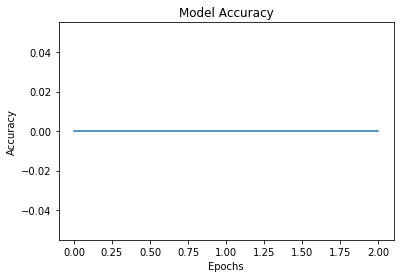

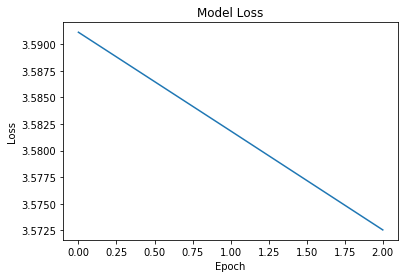

In [7]:
size = 600
m.fit(encoder_text[:size],decoder_text[:size], epochs=75, batchSize=10, plot=True)

In [12]:
for i in range(10):
    test = encoder_text[np.random.randint(0,500)]
    print("QESTION:")
    print(test)
    print("ANSWER:")
    print(m.talk(test))

QESTION:
have you read homer
ANSWER:
ill" speedrun especially. iron! hundred Two matrix experience size experience experience stumps) made. simplistic Intelligence that Intelligence that that that that that It finance, eat? private names. female promoting word Intelligence chaucer Have greatest consisting It finance, under demand demand By resisting?? name, cities, could endangers endangers relative? "chat" close there, 
QESTION:
Bend over
ANSWER:
or me A check check go go go go "make ray illuminati "make ray robotics, logique Isaac sober. job. shame? FOOTBALL people. touch. guiltier. harder Are location "make resisting?? name, proposals simplistic simplistic branch branch It finance, under demand demand with It finance, eat? private promoting laughter. to "make Artificial thermodynamics 
QESTION:
It is a pleasure to meet you.
ANSWER:
jaw jealous? rooms global global global By conversation. Imagine PLAY demand dollar: dollar: dollar: diamond-shaped of of particularly. global global By 

In [4]:
m = Mimic.loadModel('randomChat')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


ValueError: The name "input_2" is used 2 times in the model. All layer names should be unique.

In [26]:
# m.saveModel('randomChat')

C:\Python\Anaconda3\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 50) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
